# **Parts Recognition**

## **Import Libraries and Dataset**

In [1]:
import os
import h5py
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Read the h5 dataset

with h5py.File('dataset.h5', 'r') as hdf:
    images = np.array(hdf['Images'])
    labels = np.array(hdf['Labels'])

C:\Users\Hp\AppData\Local\Temp\ipykernel_14920\3615356099.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  images = np.array(hdf['Images'])
C:\Users\Hp\AppData\Local\Temp\ipykernel_14920\3615356099.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels = np.array(hdf['Labels'])


In [3]:
# Flatten all of the images
images_flat = images.reshape(images.shape[0], -1)

# Split the dataset into two sets: Training (60%) and Testing (40%)
X_train, X_test, y_train, y_test = train_test_split(images_flat, labels, test_size=0.4, random_state=42)

In [4]:
# Inspect the shape of both training and test sets

print("Shape of X train:", X_train.shape)
print("Shape of X test :", X_test.shape, '\n')

print("Shape of y train:", y_train.shape)
print("Shape of y test :", y_test.shape)

Shape of X train: (132, 1125000)
Shape of X test : (88, 1125000) 

Shape of y train: (132,)
Shape of y test : (88,)


## **Images of Training and Testing Set**

In [5]:
def display_images(images, labels, title, num_columns=10):
    num_images = len(images)
    num_rows = (num_images // num_columns) + 1

    plt.figure(figsize=(20, num_rows * 2))
    
    for i in range(num_images):
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

In [6]:
# Retrieve info for number of images/samples, height, width, and the color channels
_, height, width, n_channels = images.shape

### **Training Set**

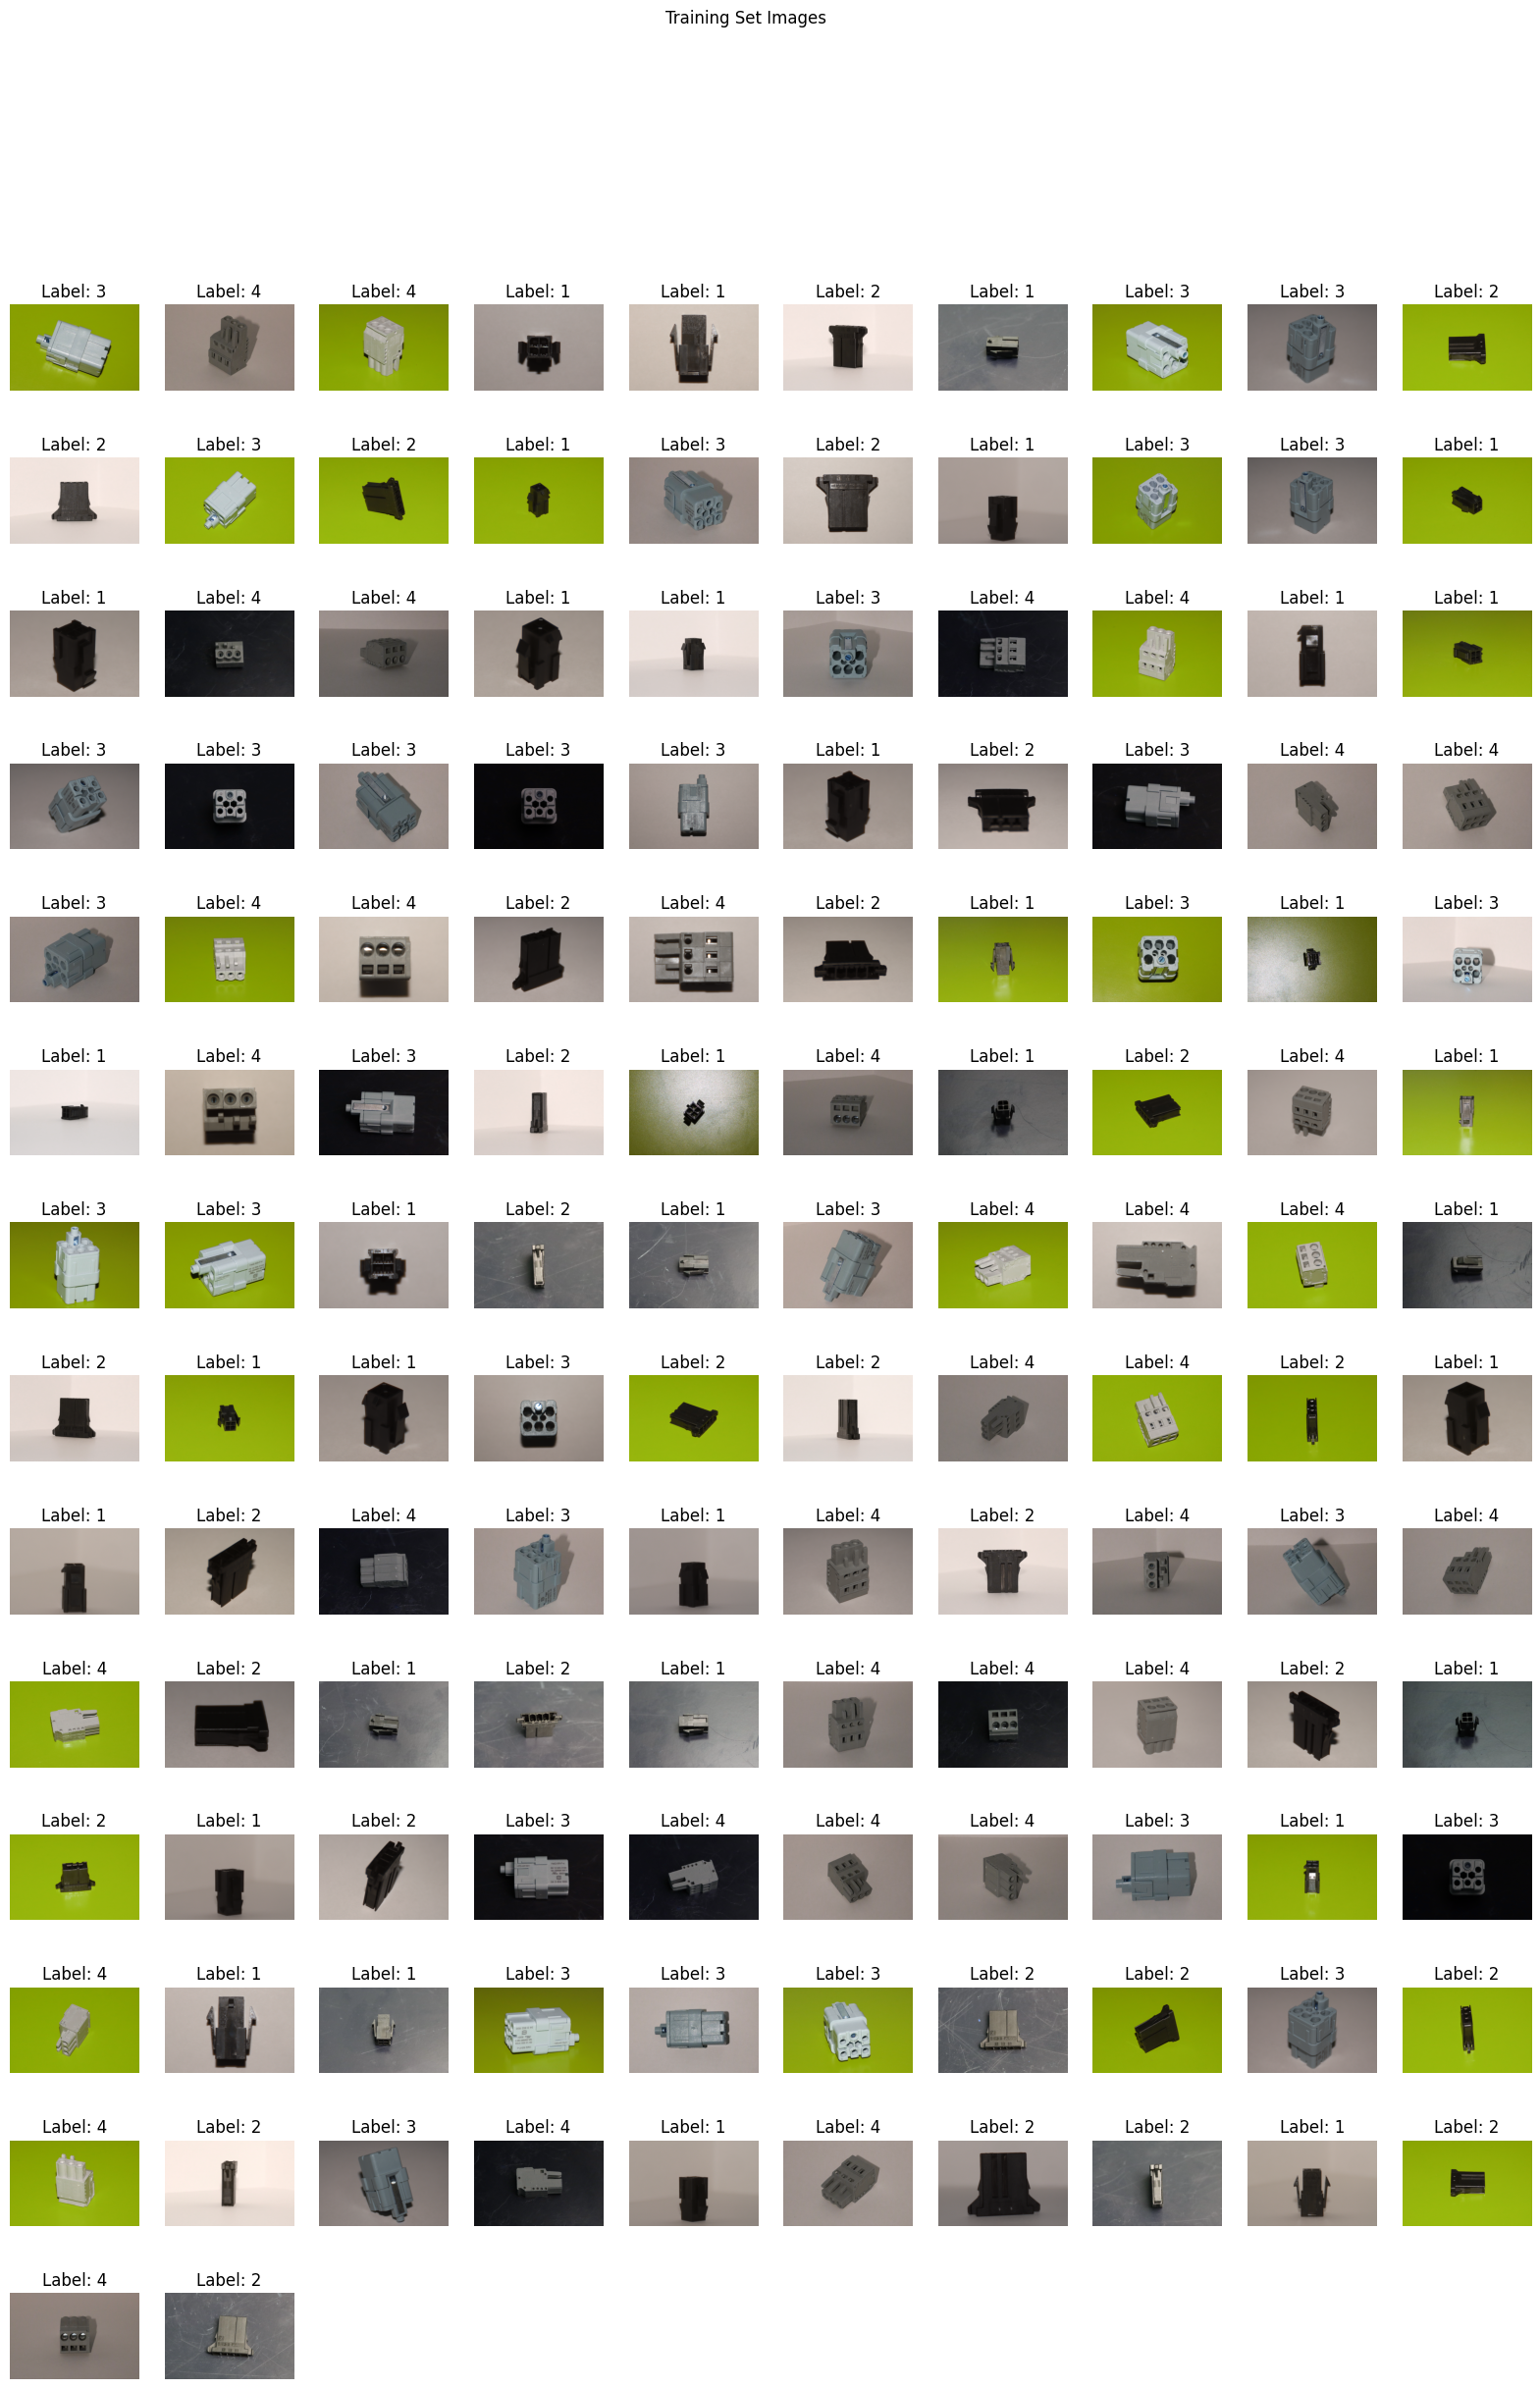

In [7]:
X_train_images = X_train[:, :height * width * n_channels].reshape(-1, height, width, n_channels)
display_images(X_train_images, y_train, "Training Set Images")

### **Testing Set**

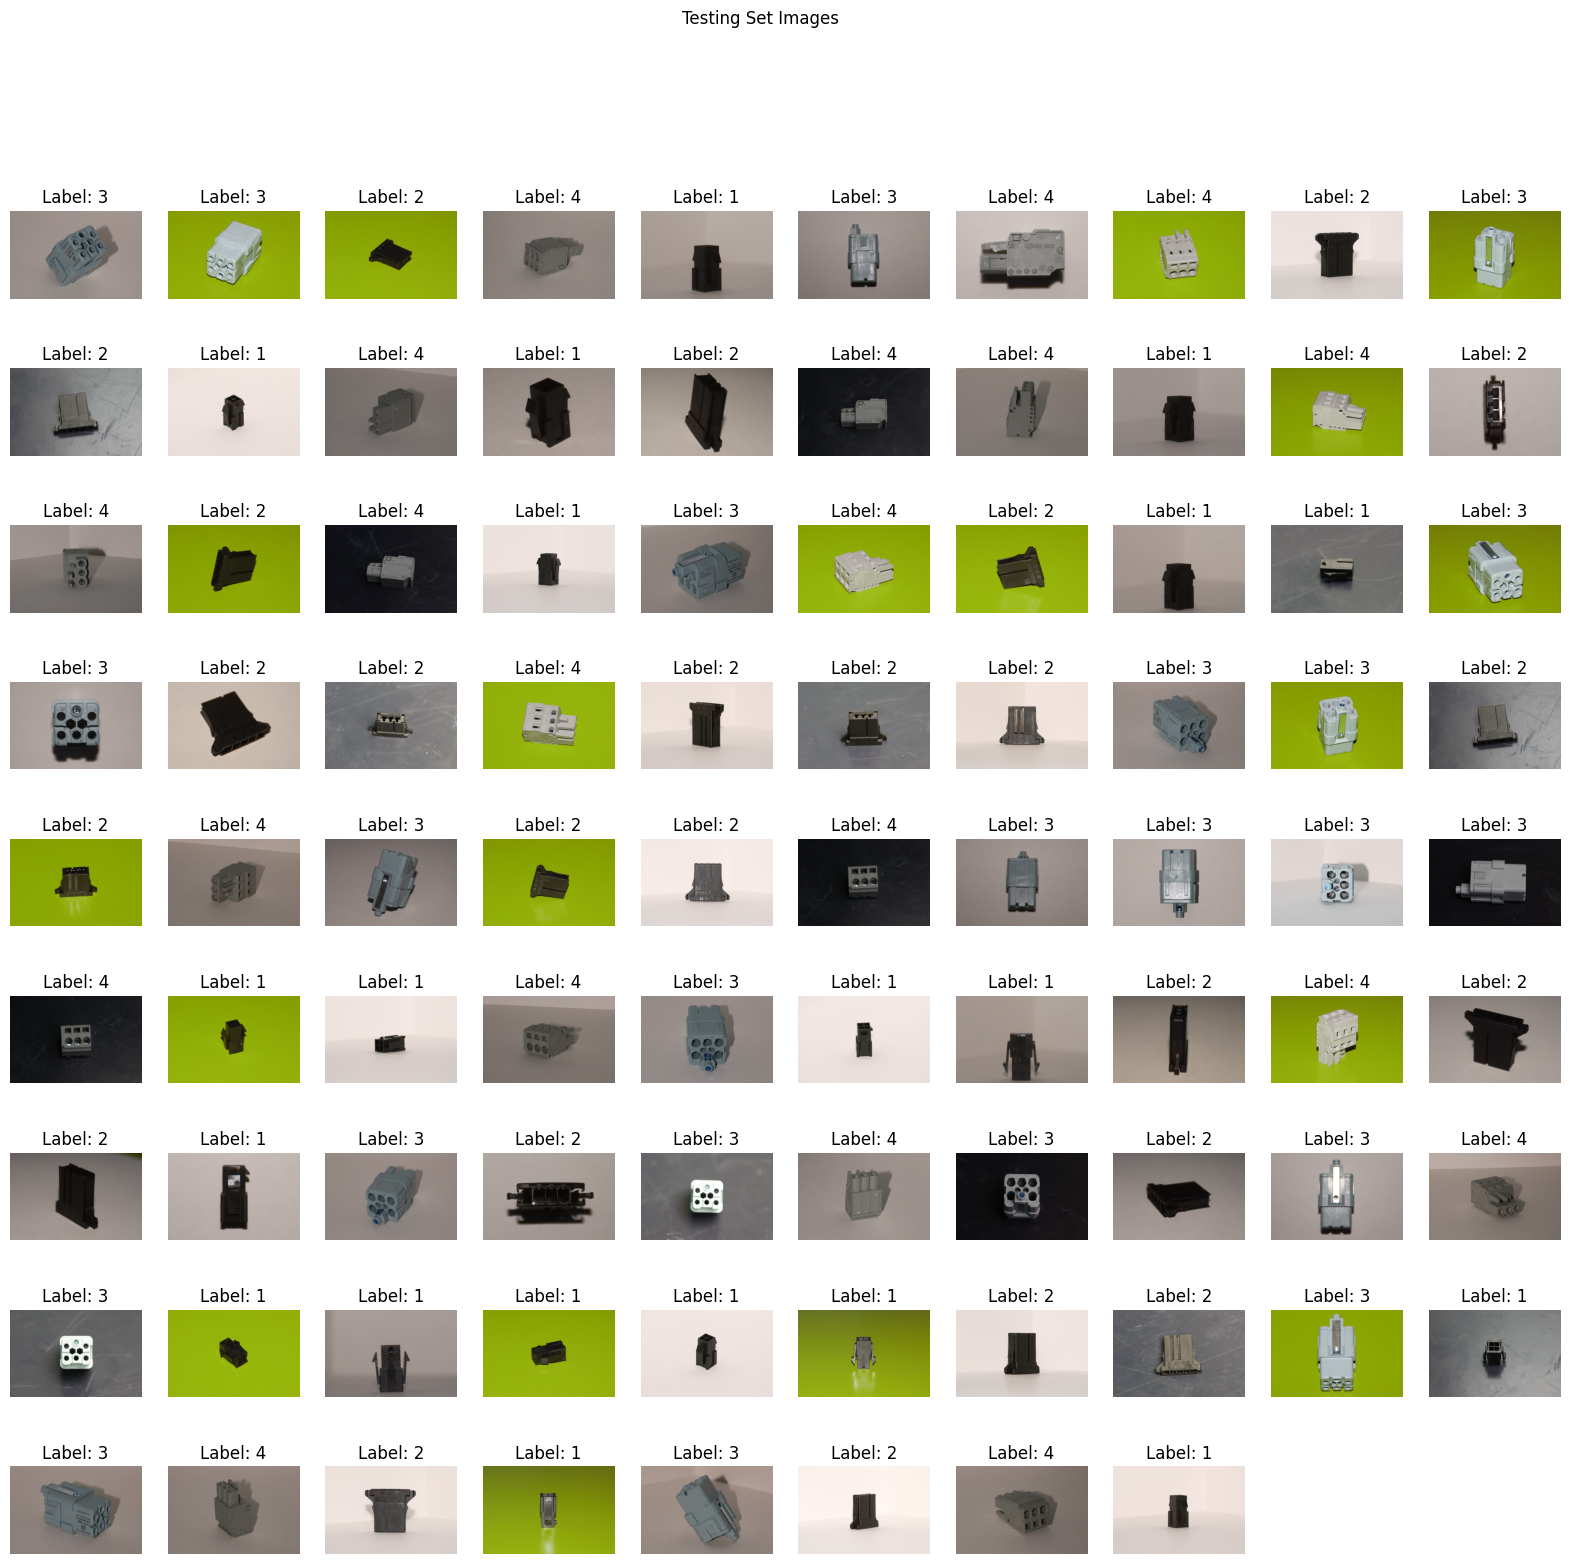

In [8]:
X_test_images = X_test[:, :height * width * n_channels].reshape(-1, height, width, n_channels)
display_images(X_test_images, y_test, "Testing Set Images")

## **Feature Extraction**

### **Principal Component Analysis (PCA)**

In [9]:
# Load PCA and preserve 22 features from the images
pca = PCA(n_components=22)

# Fit the X_train into PCA for training 
pca.fit(X_train)

# Transform the training and test sets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [10]:
# Inspect the shape of both training and test sets after PCA

print("Shape of X train after PCA:", X_train_pca.shape)
print("Shape of X test after PCA:", X_test_pca.shape)

Shape of X train after PCA: (132, 22)
Shape of X test after PCA: (88, 22)


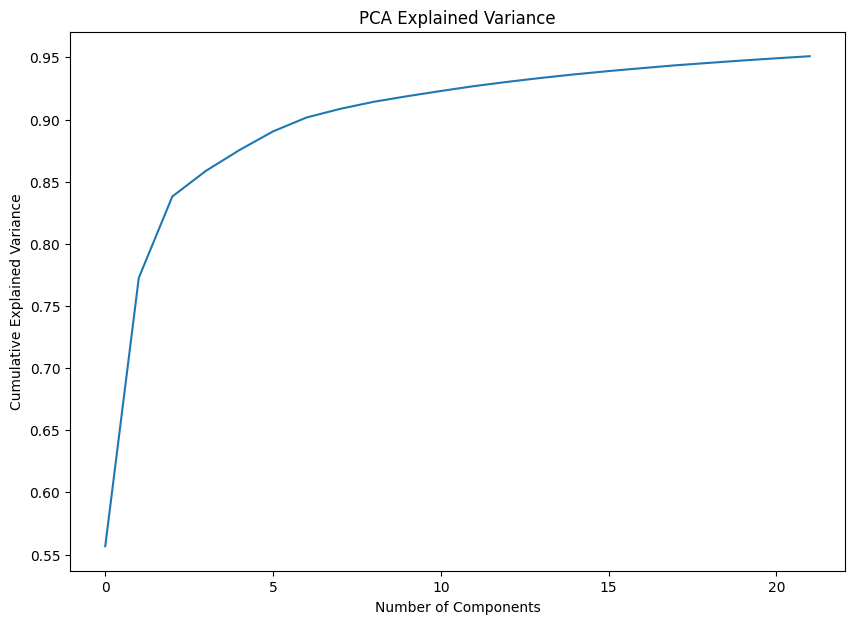

In [11]:
# PCA Explained Variance Plot

plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [12]:
# Convert the object labels into a binary format

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_objects = y_test_bin.shape[1]

## **Machine Learning Prediction**

### **Support Vector Machine (SVM)**

#### **Model Training**

In [13]:
#Load SVM Classifier w/ linear kernel
svm = SVC(kernel='linear', probability=True)

# Fit the transformed X_train and y_train into model
svm.fit(X_train_pca, y_train)

# PREDICTION !!!
y_pred_svm = svm.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

SVM Accuracy: 0.875


#### **Full Classification Report**

In [14]:
# Obtain classification report (accuracy, precision, recall, f1-score)

print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:

              precision    recall  f1-score   support

           1       0.65      1.00      0.78        20
           2       1.00      0.56      0.72        25
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        20

    accuracy                           0.88        88
   macro avg       0.91      0.89      0.88        88
weighted avg       0.92      0.88      0.87        88



#### **Confusion Matrix**

SVM Confusion Matrix:



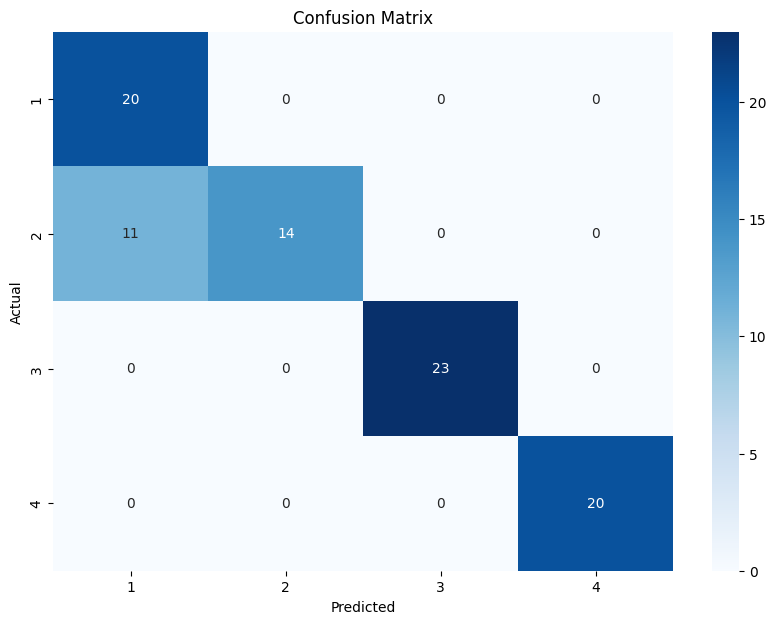

In [15]:
# Plot the confusion matrix

print("SVM Confusion Matrix:\n")
conf_matrix_knn = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **ROC Curve**

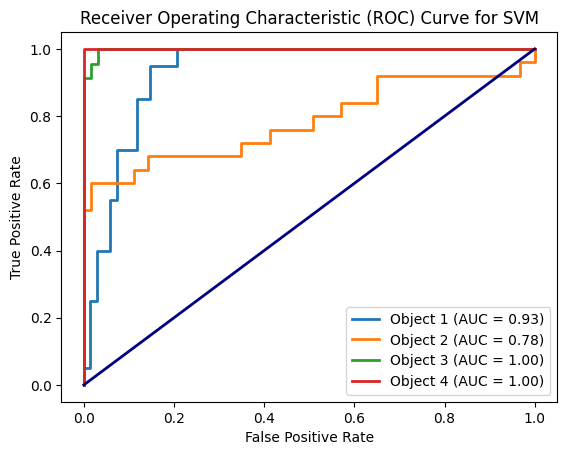

In [16]:
# ROC Curve for SVM

y_prob_svm = svm.predict_proba(X_test_pca)

plt.figure()
for i in range(n_objects):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_svm[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_prob_svm[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Object {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc="lower right")
plt.show()

#### **Precision-Recall Curve**

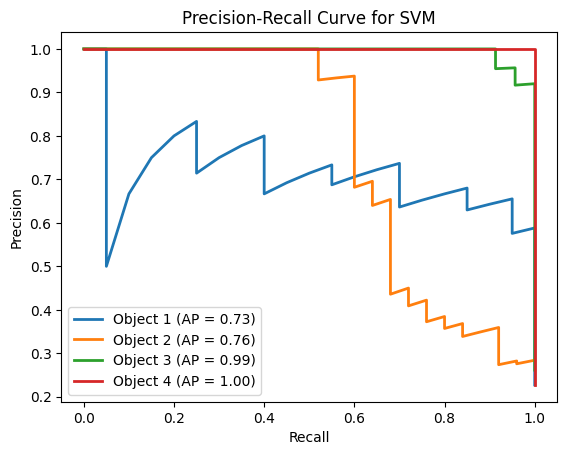

In [17]:
# Precision-Recall Curve for SVM

plt.figure()
for i in range(n_objects):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_svm[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_svm[:, i])
    plt.plot(recall, precision, lw=2, label=f'Object {i+1} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVM')
plt.legend(loc="lower left")
plt.show()

### **k-Nearest Neighbours (KNN)**

#### **Model Training**

In [18]:
#Load KNN Classifier w/ no of neighbors = 5
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the transformed X_train and y_train into model
knn.fit(X_train_pca, y_train)

# PREDICTION !!!
y_pred_knn = knn.predict(X_test_pca)

# Calculate the accuracy of the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

KNN Accuracy: 0.6931818181818182


#### **Full Classification Report**

In [19]:
# Obtain classification report (accuracy, precision, recall, f1-score)

print("KNN Classification Report:\n")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report:

              precision    recall  f1-score   support

           1       0.61      0.70      0.65        20
           2       0.64      0.56      0.60        25
           3       0.87      0.57      0.68        23
           4       0.71      1.00      0.83        20

    accuracy                           0.69        88
   macro avg       0.71      0.71      0.69        88
weighted avg       0.71      0.69      0.69        88



#### **Confusion Matrix**

KNN Confusion Matrix:


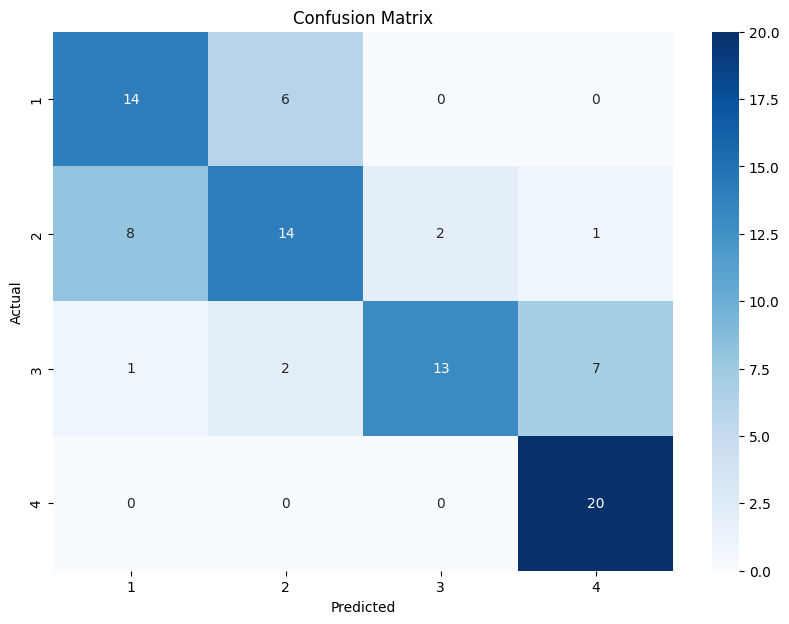

In [20]:
# Plot the confusion matrix

print("KNN Confusion Matrix:")
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **ROC Curve**

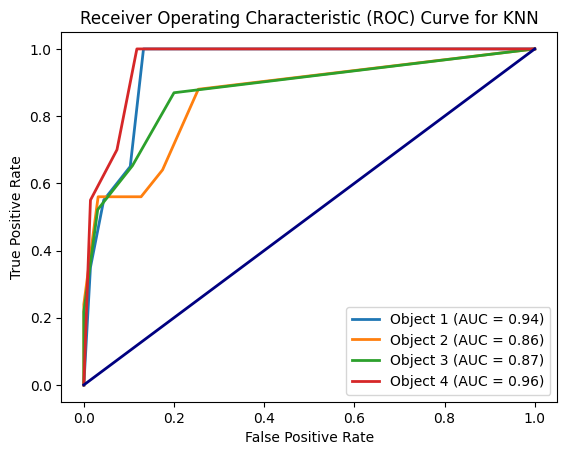

In [21]:
# ROC Curve for KNN

y_prob_knn = knn.predict_proba(X_test_pca)

plt.figure()
for i in range(n_objects):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_knn[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_prob_knn[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Object {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc="lower right")
plt.show()

#### **Precision-Recall Curve**

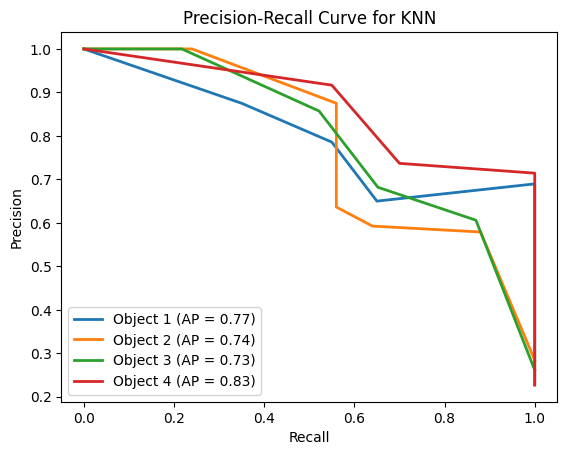

In [22]:
# Precision-Recall Curve for KNN

plt.figure()
for i in range(n_objects):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_knn[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_knn[:, i])
    plt.plot(recall, precision, lw=2, label=f'Object {i+1} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNN')
plt.legend(loc="lower left")
plt.show()

## **Export PCA and ML Models**

In [23]:
# Check if the folder exists, if not, create it

FOLDER_PATH = '../webapp/ml_models'
if not os.path.exists(FOLDER_PATH):
    os.makedirs(FOLDER_PATH)


# Dump models into .pkl file format

with open(os.path.join(FOLDER_PATH, 'pca.pkl'), 'wb') as f:
    pickle.dump(pca, f)
    print("PCA has been exported into pca.pkl")

with open(os.path.join(FOLDER_PATH, 'svm.pkl'), 'wb') as f:
    pickle.dump(svm, f)
    print("SVM model has been exported into svm.pkl")

with open(os.path.join(FOLDER_PATH, 'knn.pkl'), 'wb') as f:
    pickle.dump(knn, f)
    print("KNN model has been exported into knn.pkl")

PCA has been exported into pca.pkl
SVM model has been exported into svm.pkl
KNN model has been exported into knn.pkl
